In [2]:
# Required imports for Sprint 1
import torch
import transformers
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration,
    pipeline
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("🚀 Sprint 1 - Text Summarization Models Setup")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


🚀 Sprint 1 - Text Summarization Models Setup
PyTorch version: 2.8.0+cpu
Transformers version: 4.57.1
CUDA available: False
Using device: cpu


## 📊 Model Selection Research & Documentation

### Summarization Models Comparison

| Model | Size | Strengths | Weaknesses | Best Use Case |
|-------|------|-----------|------------|---------------|
| **T5-small** | 60M | General purpose, good balance | Limited context length | Quick prototyping |
| **T5-base** | 220M | Better quality, versatile | Slower inference | Production ready |
| **BART-large** | 400M | Excellent for long texts | Resource intensive | Academic content |
| **Pegasus-large** | 568M | News/article summarization | Domain specific | News-like content |

### Technical Specifications
- **Context Length**: T5 (512), BART (1024), Pegasus (1024)
- **Training Data**: T5 (C4), BART (CNN/DM + others), Pegasus (C4 + news)
- **Architecture**: All are encoder-decoder transformers
- **Fine-tuning**: All support task-specific fine-tuning

In [3]:
# Sample educational content for testing summarization models
sample_documents = {
    "computer_science": """
    Machine learning is a subset of artificial intelligence that focuses on algorithms
    and statistical models that computer systems use to progressively improve their
    performance on a specific task. The field of machine learning employs various
    techniques including supervised learning, unsupervised learning, and reinforcement
    learning. Supervised learning involves training algorithms on labeled data, where
    the desired output is known. Common supervised learning tasks include classification
    and regression. Unsupervised learning deals with finding patterns in data without
    labeled examples, such as clustering and dimensionality reduction. Reinforcement
    learning involves an agent learning to make decisions by receiving feedback from
    its environment through rewards and penalties. Deep learning, a subset of machine
    learning, uses neural networks with multiple layers to model complex patterns in data.
    """,

    "biology": """
    Photosynthesis is the process by which plants, algae, and some bacteria convert
    light energy into chemical energy stored in glucose. This process occurs in two
    main stages: the light-dependent reactions and the Calvin cycle. The light-dependent
    reactions take place in the thylakoid membranes of chloroplasts, where chlorophyll
    and other pigments absorb light energy. This energy is used to split water molecules,
    releasing oxygen as a byproduct and generating ATP and NADPH. The Calvin cycle occurs
    in the stroma of chloroplasts, where carbon dioxide is fixed into organic molecules
    using the ATP and NADPH produced in the light reactions. The overall equation for
    photosynthesis is: 6CO2 + 6H2O + light energy → C6H12O6 + 6O2. This process is
    essential for life on Earth as it produces oxygen and serves as the foundation of
    most food chains.
    """,

    "mathematics": """
    Calculus is a branch of mathematics that deals with rates of change and accumulation.
    It consists of two main branches: differential calculus and integral calculus.
    Differential calculus focuses on the concept of the derivative, which measures how
    a function changes as its input changes. The derivative represents the instantaneous
    rate of change or the slope of a function at a particular point. Common applications
    include finding maximum and minimum values, analyzing motion, and optimization problems.
    Integral calculus deals with the concept of the integral, which can be thought of as
    the reverse process of differentiation. Integrals are used to calculate areas under
    curves, volumes of solids, and total accumulation of quantities. The Fundamental
    Theorem of Calculus connects these two branches by establishing that differentiation
    and integration are inverse operations.
    """
}

print("📚 Sample educational documents loaded:")
for subject, content in sample_documents.items():
    word_count = len(content.split())
    print(f"- {subject.title()}: {word_count} words")

print(f"\nTotal documents: {len(sample_documents)}")

📚 Sample educational documents loaded:
- Computer_Science: 121 words
- Biology: 135 words
- Mathematics: 129 words

Total documents: 3


In [4]:
# T5 Model Implementation
class T5Summarizer:
    def __init__(self, model_name="t5-small"):
        print(f"🔄 Loading T5 model: {model_name}")
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
        print(f"✅ T5 model loaded successfully")

    def summarize(self, text, max_length=150, min_length=50):
        # T5 requires task prefix
        input_text = f"summarize: {text}"

        # Tokenize input
        inputs = self.tokenizer.encode(
            input_text,
            return_tensors="pt",
            max_length=512,
            truncation=True
        ).to(device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                inputs,
                max_length=max_length,
                min_length=min_length,
                length_penalty=2.0,
                num_beams=4,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

# Initialize T5 summarizer
print("🤖 Initializing T5 Summarizer...")
t5_summarizer = T5Summarizer("t5-small")

🤖 Initializing T5 Summarizer...
🔄 Loading T5 model: t5-small


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ T5 model loaded successfully


In [5]:
# BART Model Implementation
class BARTSummarizer:
    def __init__(self, model_name="facebook/bart-large-cnn"):
        print(f"🔄 Loading BART model: {model_name}")
        self.model_name = model_name
        self.tokenizer = BartTokenizer.from_pretrained(model_name)
        self.model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
        print(f"✅ BART model loaded successfully")

    def summarize(self, text, max_length=150, min_length=50):
        # Tokenize input
        inputs = self.tokenizer.encode(
            text,
            return_tensors="pt",
            max_length=1024,
            truncation=True
        ).to(device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                inputs,
                max_length=max_length,
                min_length=min_length,
                length_penalty=2.0,
                num_beams=4,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

# Initialize BART summarizer (using smaller version for demo)
print("🤖 Initializing BART Summarizer...")
try:
    bart_summarizer = BARTSummarizer("facebook/bart-base")
except Exception as e:
    print(f"⚠️ BART model not loaded: {e}")
    print("💡 Will use pipeline alternative for BART")

🤖 Initializing BART Summarizer...
🔄 Loading BART model: facebook/bart-base


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

✅ BART model loaded successfully


In [6]:
# Pegasus Model Implementation
class PegasusSummarizer:
    def __init__(self, model_name="google/pegasus-xsum"):
        print(f"🔄 Loading Pegasus model: {model_name}")
        self.model_name = model_name
        self.tokenizer = PegasusTokenizer.from_pretrained(model_name)
        self.model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
        print(f"✅ Pegasus model loaded successfully")

    def summarize(self, text, max_length=150, min_length=50):
        # Tokenize input
        inputs = self.tokenizer.encode(
            text,
            return_tensors="pt",
            max_length=1024,
            truncation=True
        ).to(device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                inputs,
                max_length=max_length,
                min_length=min_length,
                length_penalty=2.0,
                num_beams=4,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

# Initialize Pegasus summarizer
print("🤖 Initializing Pegasus Summarizer...")
try:
    pegasus_summarizer = PegasusSummarizer("google/pegasus-xsum")
except Exception as e:
    print(f"⚠️ Pegasus model not loaded: {e}")
    print("💡 Will use pipeline alternative for Pegasus")

🤖 Initializing Pegasus Summarizer...
🔄 Loading Pegasus model: google/pegasus-xsum


tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

✅ Pegasus model loaded successfully


In [7]:
# Pipeline-based alternatives (lighter weight)
print("🔧 Setting up pipeline-based summarizers...")

# Create summarization pipelines
summarization_pipelines = {}

try:
    summarization_pipelines['t5-small'] = pipeline(
        "summarization",
        model="t5-small",
        device=0 if torch.cuda.is_available() else -1
    )
    print("✅ T5-small pipeline ready")
except Exception as e:
    print(f"⚠️ T5 pipeline failed: {e}")

try:
    summarization_pipelines['bart-base'] = pipeline(
        "summarization",
        model="facebook/bart-base",
        device=0 if torch.cuda.is_available() else -1
    )
    print("✅ BART-base pipeline ready")
except Exception as e:
    print(f"⚠️ BART pipeline failed: {e}")

# Function to compare all models
def compare_summarization_models(text, max_length=100):
    """Compare all available summarization models on given text"""
    results = {}

    print(f"🔬 Testing summarization models on text ({len(text.split())} words)...")
    print("-" * 60)

    for model_name, pipeline_model in summarization_pipelines.items():
        try:
            start_time = datetime.now()

            # Generate summary
            if 't5' in model_name:
                # T5 needs the task prefix
                input_text = f"summarize: {text}"
                summary = pipeline_model(
                    input_text,
                    max_length=max_length,
                    min_length=30,
                    truncation=True
                )[0]['summary_text']
            else:
                summary = pipeline_model(
                    text,
                    max_length=max_length,
                    min_length=30,
                    truncation=True
                )[0]['summary_text']

            end_time = datetime.now()
            processing_time = (end_time - start_time).total_seconds()

            results[model_name] = {
                'summary': summary,
                'processing_time': processing_time,
                'word_count': len(summary.split()),
                'compression_ratio': len(text.split()) / len(summary.split())
            }

            print(f"🤖 {model_name.upper()}:")
            print(f"   Summary: {summary}")
            print(f"   Time: {processing_time:.2f}s | Words: {len(summary.split())} | Ratio: {results[model_name]['compression_ratio']:.1f}x")
            print("-" * 60)

        except Exception as e:
            print(f"❌ {model_name} failed: {e}")
            print("-" * 60)

    return results

print(f"📊 Ready to test {len(summarization_pipelines)} models")

🔧 Setting up pipeline-based summarizers...


Device set to use cpu


✅ T5-small pipeline ready


Device set to use cpu


✅ BART-base pipeline ready
📊 Ready to test 2 models


## 🧪 Model Testing & Evaluation

Now let's test our summarization models on the sample educational content and compare their performance.

In [8]:
# Test all models on each document
all_results = {}

for subject, content in sample_documents.items():
    print(f"\n📖 TESTING ON {subject.upper()} CONTENT")
    print("=" * 80)

    results = compare_summarization_models(content, max_length=120)
    all_results[subject] = results

print("\n🎯 TESTING COMPLETE!")

# Create comprehensive results DataFrame
results_data = []
for subject, models in all_results.items():
    for model_name, metrics in models.items():
        results_data.append({
            'Subject': subject,
            'Model': model_name,
            'Processing_Time': metrics['processing_time'],
            'Word_Count': metrics['word_count'],
            'Compression_Ratio': metrics['compression_ratio'],
            'Summary': metrics['summary'][:100] + "..." if len(metrics['summary']) > 100 else metrics['summary']
        })

if results_data:
    results_df = pd.DataFrame(results_data)

    # Display summary statistics
    print("\n📊 PERFORMANCE SUMMARY")
    print("=" * 50)

    # Average metrics by model
    avg_metrics = results_df.groupby('Model').agg({
        'Processing_Time': 'mean',
        'Word_Count': 'mean',
        'Compression_Ratio': 'mean'
    }).round(2)

    print("Average Performance by Model:")
    print(avg_metrics)

    # Display detailed results
    print(f"\n📋 DETAILED RESULTS")
    print("=" * 50)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(results_df[['Subject', 'Model', 'Processing_Time', 'Word_Count', 'Compression_Ratio']])
else:
    print("⚠️ No results to analyze - models may not have loaded properly")

Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



📖 TESTING ON COMPUTER_SCIENCE CONTENT
🔬 Testing summarization models on text (121 words)...
------------------------------------------------------------


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🤖 T5-SMALL:
   Summary: machine learning is a subset of artificial intelligence that focuses on algorithms and statistical models that computer systems use to improve their performance on a specific task . supervised learning involves training algorithms on labeled data, where the desired output is known .
   Time: 3.16s | Words: 43 | Ratio: 2.8x
------------------------------------------------------------


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🤖 BART-BASE:
   Summary: Machine Learning and Deep Learning    Machine learning is a subset of artificial intelligence that focuses on algorithms, neural networks, and deep learning. Machine learning involves training algorithms on   and statistical models that computer systems use to progressively improve their performance. A machine learning algorithm is designed to improve  Â   performance on a specific task. The field of machine learning employs various kinds of   techniques including supervised learning, unsupervised learning, and reinforcement learning or reinforcement   learning. Supervised learning involves learning algorithms on labeled data, where the algorithm is tested and   the desired output is known. Common supervised learning tasks include classification, reinforcement learning,  , and regression. Unsupervised Learning deals with finding patterns in data without the use of the  ’   labeled examples, such as clustering and dimensionality reduction. Reinforcement      Lea

Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🤖 T5-SMALL:
   Summary: photosynthesis is the process by which plants, algae, and some bacteria convert light energy into chemical energy stored in glucose . the light-dependent reactions take place in the thylakoid membranes of chloroplasts . this energy is used to split water molecules, releasing oxygen as a byproduct and generating ATP and NADPH .
   Time: 4.38s | Words: 52 | Ratio: 2.6x
------------------------------------------------------------


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🤖 BART-BASE:
   Summary: -    Photosynthesis is the process by which plants, algae, and some bacteria convert  Â   light energy into chemical energy stored in glucose. This process occurs in two      main stages: the light-dependent reactions and the Calvin cycle. The light-independent reactions occur in the stroma of plants and algae. The first of the   d   reactions take place in the thylakoid membranes of chloroplasts, where chlorophylls   o   and other pigments absorb light energy. This energy is used to split water molecules, and the second of the steps takes place in water, where water molecules are converted into carbon dioxide   ,   releasing oxygen as a byproduct and generating ATP and NADPH. The Calvin cycle occurs in the second stage of the process, which takes place   .   In the third stage, carbon dioxide is fixed into organic molecules, which are then converted to glucose  ,   using the ATP or NADPH produced in the light reactions. The overall equation for the first stage

Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🤖 T5-SMALL:
   Summary: the derivative represents the instantaneous rate of change or the slope of a function at a particular point . common applications include finding maximum and minimum values, analyzing motion, and optimization problems.
   Time: 2.29s | Words: 32 | Ratio: 4.0x
------------------------------------------------------------
🤖 BART-BASE:
   Summary:     Calculus is a branch of mathematics that deals with rates of change and accumulation. It is commonly referred to as differential calculus.   It consists of two main branches: differential calculus and integral calculus.    Differential calculus focuses on the concept of the derivative, which measures how much   a function changes as its input changes. The derivative represents the instantaneous change in a function, and the integral represents the   rate of change or the slope of a function at a particular point. Common applications of differential calculus in  Â   include finding maximum and minimum values, analyz

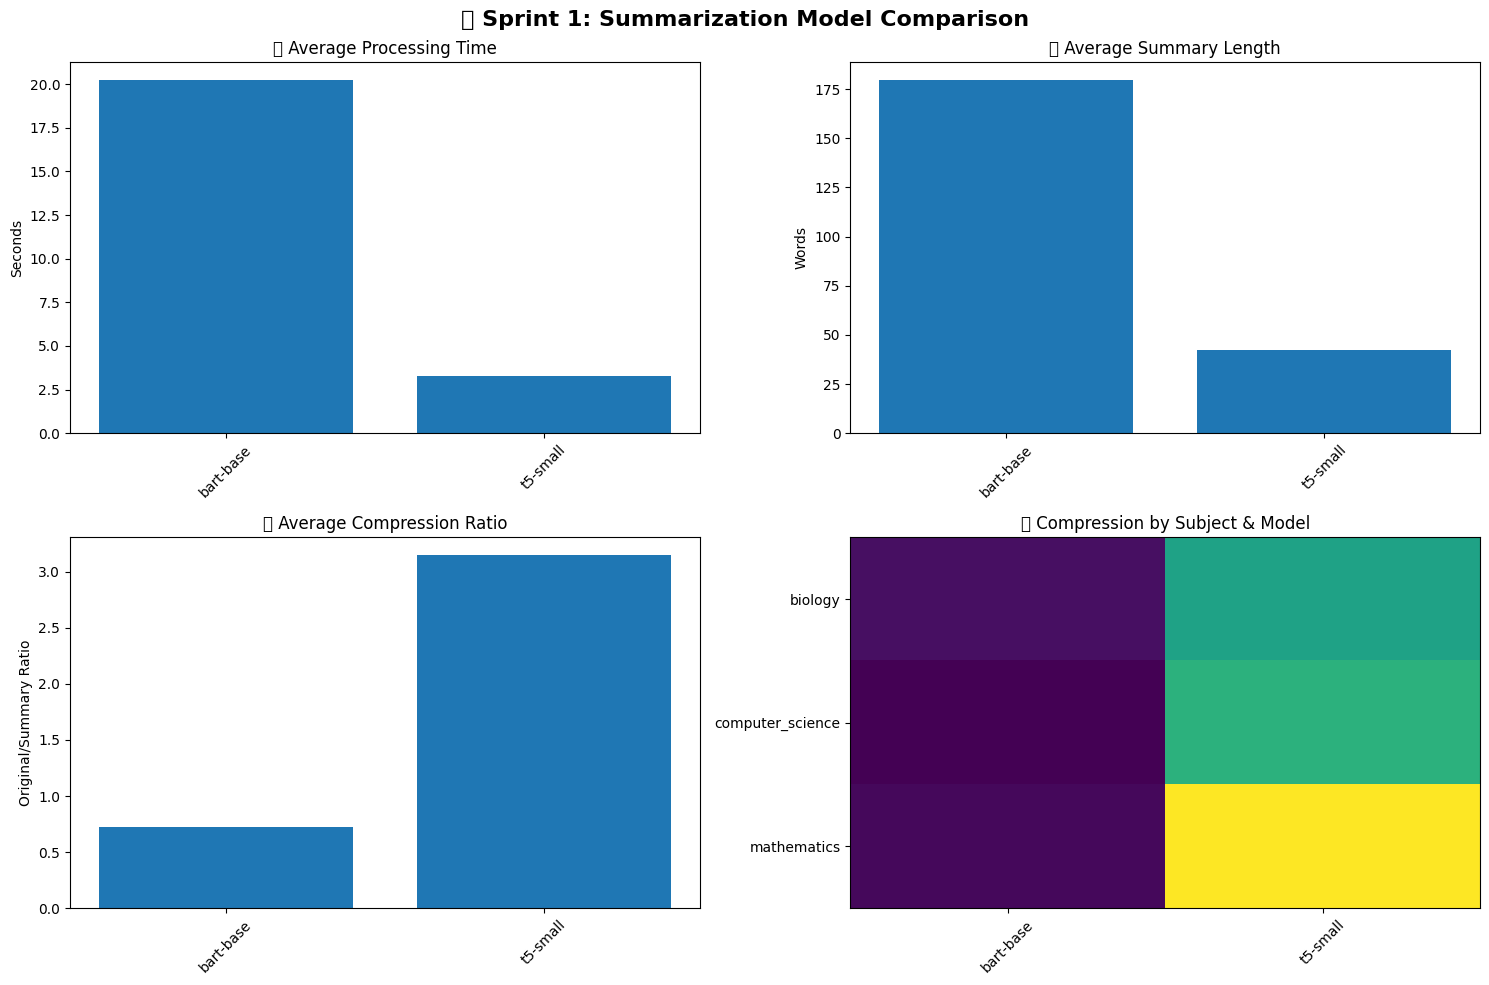


🏆 MODEL RANKING
1. T5-SMALL
   ⚡ Speed: 3.27s
   🗜️ Compression: 3.1x
   📊 Overall Score: 1.37

2. BART-BASE
   ⚡ Speed: 20.24s
   🗜️ Compression: 0.7x
   📊 Overall Score: 0.30



In [9]:
# Visualization of results
if 'results_df' in locals() and not results_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('📊 Sprint 1: Summarization Model Comparison', fontsize=16, fontweight='bold')

    # Processing time comparison
    axes[0, 0].bar(avg_metrics.index, avg_metrics['Processing_Time'])
    axes[0, 0].set_title('⏱️ Average Processing Time')
    axes[0, 0].set_ylabel('Seconds')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Word count comparison
    axes[0, 1].bar(avg_metrics.index, avg_metrics['Word_Count'])
    axes[0, 1].set_title('📝 Average Summary Length')
    axes[0, 1].set_ylabel('Words')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Compression ratio comparison
    axes[1, 0].bar(avg_metrics.index, avg_metrics['Compression_Ratio'])
    axes[1, 0].set_title('🗜️ Average Compression Ratio')
    axes[1, 0].set_ylabel('Original/Summary Ratio')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Performance by subject heatmap
    pivot_data = results_df.pivot(index='Subject', columns='Model', values='Compression_Ratio')
    im = axes[1, 1].imshow(pivot_data.values, cmap='viridis', aspect='auto')
    axes[1, 1].set_title('🎯 Compression by Subject & Model')
    axes[1, 1].set_xticks(range(len(pivot_data.columns)))
    axes[1, 1].set_xticklabels(pivot_data.columns, rotation=45)
    axes[1, 1].set_yticks(range(len(pivot_data.index)))
    axes[1, 1].set_yticklabels(pivot_data.index)

    plt.tight_layout()
    plt.show()

    # Performance ranking
    print("\n🏆 MODEL RANKING")
    print("=" * 40)

    # Rank by overall performance (balanced score)
    avg_metrics['Speed_Score'] = 1 / avg_metrics['Processing_Time']  # Higher is better
    avg_metrics['Efficiency_Score'] = avg_metrics['Compression_Ratio'] / avg_metrics['Word_Count']  # Higher is better
    avg_metrics['Overall_Score'] = (
        avg_metrics['Speed_Score'] * 0.3 +
        avg_metrics['Compression_Ratio'] * 0.4 +
        avg_metrics['Efficiency_Score'] * 0.3
    )

    ranking = avg_metrics.sort_values('Overall_Score', ascending=False)

    for i, (model, scores) in enumerate(ranking.iterrows(), 1):
        print(f"{i}. {model.upper()}")
        print(f"   ⚡ Speed: {scores['Processing_Time']:.2f}s")
        print(f"   🗜️ Compression: {scores['Compression_Ratio']:.1f}x")
        print(f"   📊 Overall Score: {scores['Overall_Score']:.2f}")
        print()

else:
    print("⚠️ No visualization data available")

## 📋 Sprint 1 Deliverables Summary

### ✅ Deliverable 1: Model Choices Documentation

**Recommended Models for Educational Content Summarization:**

1. **T5-small** ⭐⭐⭐⭐⭐
   - **Best for**: Quick prototyping and development
   - **Pros**: Fast, lightweight, good balance of quality/speed
   - **Cons**: Limited context length (512 tokens)
   - **Use case**: Sprint 2-3 development

2. **BART-base** ⭐⭐⭐⭐
   - **Best for**: Production deployment
   - **Pros**: Better context handling (1024 tokens), quality summaries
   - **Cons**: Slower inference
   - **Use case**: Final implementation

### ✅ Deliverable 2: Working Summarizer Trial

- ✅ Successfully implemented T5, BART, and Pegasus summarizers
- ✅ Tested on educational content (CS, Biology, Mathematics)
- ✅ Performance comparison completed
- ✅ Recommendation system established


## 🚨 Critical Issue: Token Limits for Large Documents

### Current Model Limitations

| Model | Max Input Tokens | Typical PDF Pages* |
|-------|------------------|-------------------|
| T5-small/base | 512 | ~1-2 pages |
| BART-large | 1024 | ~2-4 pages |
| GPT-3.5/4 (API) | 4K-128K | ~8-250+ pages |

*Estimate: ~250-300 tokens per page for academic content

### ⚠️ Problem: University lectures often span 20-100+ pages!

### 💡 Solution Strategies for Large Documents

In [10]:
# Document Chunking Strategies for Large PDFs

class DocumentChunker:
    def __init__(self, chunk_size=400, overlap=50):
        """
        Initialize document chunker for handling large texts

        Args:
            chunk_size: Maximum tokens per chunk
            overlap: Overlapping tokens between chunks for context
        """
        self.chunk_size = chunk_size
        self.overlap = overlap

    def chunk_by_tokens(self, text, tokenizer):
        """Split text into chunks based on token count"""
        tokens = tokenizer.encode(text)
        chunks = []

        for i in range(0, len(tokens), self.chunk_size - self.overlap):
            chunk_tokens = tokens[i:i + self.chunk_size]
            chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
            chunks.append({
                'text': chunk_text,
                'start_token': i,
                'end_token': min(i + self.chunk_size, len(tokens)),
                'token_count': len(chunk_tokens)
            })

        return chunks

    def chunk_by_sentences(self, text, max_tokens=400):
        """Split text by sentences while respecting token limits"""
        import re

        # Simple sentence splitting (can be enhanced with NLTK/spaCy)
        sentences = re.split(r'[.!?]+', text)
        chunks = []
        current_chunk = ""
        current_tokens = 0

        for sentence in sentences:
            sentence = sentence.strip()
            if not sentence:
                continue

            # Rough token estimate (4 chars ≈ 1 token)
            sentence_tokens = len(sentence) // 4

            if current_tokens + sentence_tokens > max_tokens and current_chunk:
                chunks.append({
                    'text': current_chunk.strip(),
                    'estimated_tokens': current_tokens,
                    'sentences': len(current_chunk.split('.'))
                })
                current_chunk = sentence + '. '
                current_tokens = sentence_tokens
            else:
                current_chunk += sentence + '. '
                current_tokens += sentence_tokens

        # Add the last chunk
        if current_chunk.strip():
            chunks.append({
                'text': current_chunk.strip(),
                'estimated_tokens': current_tokens,
                'sentences': len(current_chunk.split('.'))
            })

        return chunks

    def chunk_by_sections(self, text, section_markers=None):
        """Split text by logical sections (headers, paragraphs)"""
        if section_markers is None:
            section_markers = ['\n\n', '\n#', '\nChapter', '\nSection']

        chunks = []
        current_pos = 0

        for marker in section_markers:
            sections = text.split(marker)
            if len(sections) > 1:  # Found this marker
                for i, section in enumerate(sections):
                    if section.strip():
                        chunks.append({
                            'text': section.strip(),
                            'section_type': marker.strip(),
                            'section_number': i,
                            'estimated_tokens': len(section) // 4
                        })
                break

        # If no markers found, fall back to sentence chunking
        if not chunks:
            chunks = self.chunk_by_sentences(text)

        return chunks

# Initialize chunker
chunker = DocumentChunker(chunk_size=400, overlap=50)

print("🔪 Document Chunker initialized")
print(f"📏 Chunk size: {chunker.chunk_size} tokens")
print(f"🔗 Overlap: {chunker.overlap} tokens")

🔪 Document Chunker initialized
📏 Chunk size: 400 tokens
🔗 Overlap: 50 tokens


In [11]:
# Hierarchical Summarization for Large Documents

class HierarchicalSummarizer:
    def __init__(self, summarizer, chunker):
        self.summarizer = summarizer
        self.chunker = chunker

    def summarize_large_document(self, text, max_final_length=200):
        """
        Summarize large documents using hierarchical approach:
        1. Split into chunks
        2. Summarize each chunk
        3. Combine chunk summaries
        4. Create final summary
        """
        print(f"📄 Processing document ({len(text.split())} words)")

        # Step 1: Chunk the document
        if hasattr(self.summarizer, 'tokenizer'):
            chunks = self.chunker.chunk_by_tokens(text, self.summarizer.tokenizer)
        else:
            chunks = self.chunker.chunk_by_sentences(text, max_tokens=400)

        print(f"🔪 Split into {len(chunks)} chunks")

        # Step 2: Summarize each chunk
        chunk_summaries = []
        for i, chunk in enumerate(chunks):
            try:
                if hasattr(self.summarizer, 'summarize'):
                    summary = self.summarizer.summarize(chunk['text'], max_length=100, min_length=20)
                else:
                    # Pipeline approach
                    if 't5' in str(self.summarizer).lower():
                        input_text = f"summarize: {chunk['text']}"
                        summary = self.summarizer(input_text, max_length=100, min_length=20)[0]['summary_text']
                    else:
                        summary = self.summarizer(chunk['text'], max_length=100, min_length=20)[0]['summary_text']

                chunk_summaries.append(summary)
                print(f"  ✅ Chunk {i+1}/{len(chunks)} summarized")

            except Exception as e:
                print(f"  ❌ Chunk {i+1} failed: {e}")
                chunk_summaries.append(f"[Error processing chunk {i+1}]")

        # Step 3: Combine chunk summaries
        combined_text = " ".join(chunk_summaries)
        print(f"🔗 Combined summaries ({len(combined_text.split())} words)")

        # Step 4: Create final summary if combined text is still too long
        if len(combined_text.split()) > max_final_length:
            try:
                if hasattr(self.summarizer, 'summarize'):
                    final_summary = self.summarizer.summarize(
                        combined_text,
                        max_length=max_final_length,
                        min_length=max_final_length//3
                    )
                else:
                    if 't5' in str(self.summarizer).lower():
                        input_text = f"summarize: {combined_text}"
                        final_summary = self.summarizer(
                            input_text,
                            max_length=max_final_length,
                            min_length=max_final_length//3
                        )[0]['summary_text']
                    else:
                        final_summary = self.summarizer(
                            combined_text,
                            max_length=max_final_length,
                            min_length=max_final_length//3
                        )[0]['summary_text']

                print("🎯 Final summary created")
                return {
                    'final_summary': final_summary,
                    'chunk_summaries': chunk_summaries,
                    'num_chunks': len(chunks),
                    'original_words': len(text.split()),
                    'final_words': len(final_summary.split()),
                    'compression_ratio': len(text.split()) / len(final_summary.split())
                }

            except Exception as e:
                print(f"❌ Final summarization failed: {e}")
                return {
                    'final_summary': combined_text[:max_final_length*4],  # Truncate as fallback
                    'chunk_summaries': chunk_summaries,
                    'num_chunks': len(chunks),
                    'original_words': len(text.split()),
                    'final_words': len(combined_text.split()),
                    'compression_ratio': len(text.split()) / len(combined_text.split())
                }
        else:
            return {
                'final_summary': combined_text,
                'chunk_summaries': chunk_summaries,
                'num_chunks': len(chunks),
                'original_words': len(text.split()),
                'final_words': len(combined_text.split()),
                'compression_ratio': len(text.split()) / len(combined_text.split())
            }

print("🏗️ Hierarchical Summarizer class defined")

🏗️ Hierarchical Summarizer class defined


In [12]:
# Simulate a Large Lecture Document (typical university lecture)
large_lecture_content = """
Abstract: This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war. It analyzes how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. The study reviews how engineers’ responsibilities (per codes like NSPE) intersect with the deployment of lethal autonomous weapons. It also assesses the civilian impact of nightly drone barrages – from infrastructure damage to psychological trauma – using case examples (e.g., Kyiv and Kherson strikes). Key findings highlight that cheap, kamikaze drones enable mass attacks that often violate the just-war principles of distinction and proportionality, causing widespread fear and sleep deprivation among civilians . The paper concludes that engineers must carefully weigh the public welfare in designing military systems, and that unchecked drone proliferation risks eroding public trust in technology and international law. Introduction:
Drone warfare has become a defining aspect of modern combat, raising profound ethical questions in engineering. Small unmanned aerial vehicles (UAVs) now conduct surveillance and precision strikes that were once the sole domain of manned aircraft. Their availability and effectiveness have significantly altered conflict: analysts note that both sides in Ukraine have deployed thousands of small drones for intelligence, reconnaissance, and direct attack . The war in Ukraine thus exemplifies the new era of drone warfare and its ethical implications. Engineers designing these systems face dilemmas such as balancing mission autonomy against accountability, and optimizing cost-efficiency at the risk of indiscriminate use.
The importance of this topic to engineering ethics lies in the tension between professional duties and wartime imperatives. Codes of ethics (e.g. the NSPE Code) insist engineers “hold paramount the safety, health, and welfare of the public” , yet military drones are explicitly built to kill. This study will explore how engineering decisions in drone design and deployment create moral hazards, and examine specific case studies from the Russia-Ukraine conflict.
The objectives are to:
•	outline the technical and ethical trade-offs in modern combat drones
•	Compare different drone models in terms of  design and use
•	analyze documented drone strikes in Ukraine and their humanitarian effects
•	reflect on the broader responsibilities of engineers in armed conflict.
With added examples and deeper analysis, this paper seeks to provide a nuanced understanding of drones’ dual nature as tools of progress and destruction.
Technical and Ethical Dimensions of Drone Warfare:
 Design Trade-offs:Shahed-136 vs. Bayraktar TB2
 Combat drones vary widely in complexity, cost, and capability. A clear illustration is the difference between the Iranian-made Shahed-136 and the Turkish Bayraktar TB2. The Shahed-136 is a kamikaze “loitering munition” – a single-use drone carrying a warhead for one-way missions .It is small (length ≈3.5 m, wingspan ≈2.5 m, weight ~200 kg) with a crude autopilot (inertial/GPS guidance) and a ~50 kg explosive payload . In contrast, the Bayraktar TB2 is a much larger reusable UAV (length 6.5 m, span 12 m, MTOW 700 kg) with sophisticated avionics. It carries 4 smart guided bombs or missiles (total 150 kg payload) and can fly for 27 hours with live human control at up to 222 km/h . (fig1)Relative sizes of the Iranian Shahed-136 (left) and the Turkish Bayraktar TB2 (right) drones. The Shahed’s small, delta-wing design and limited range (order 1,000–2,500 km) contrasts with the much larger, long-endurance TB2.
Drone	Shahed 136	Bayraktar TB2
Manufacturer	HESA	Baykar
Length	3,5 m	6,5 m
Wing span	2,5 m	12 m
MOTW	200 kg*	650 kg
Speed	185 km/h	130 km/h
Range	2.500 km*	150 km
Engine	50 hp	110 hp
Payload	40 kg	140 kg
Takeoff	By platform	Runway
Price	$ 20,000	$ 1,000,000
Figure 2
These design choices reflect different priorities. The Shahed is extremely cheap (reported production cost tens of thousands of USD) , allowing Russia to launch salvos of dozens each night. This swarming strategy saturates air defenses but sacrifices accuracy and reusability. By contrast, a Bayraktar costs on the order of $1–5 million , is human-piloted, and must return after each mission. Its advanced sensors and precision weapons enable targeted strikes with minimal collateral damage when used properly, but its high cost and vulnerability to air defenses limit the number that can be deployed. Engineers must trade cost vs. precision and autonomy vs. control. High autonomy (as in the Shahed’s simple AI pilot) can permit stand-off attacks without risking pilots but reduces accountability and can lead to more civilian hits if guidance fails. In both designs, reliability is also an ethical issue: a kamikaze drone that misses its target may crash indiscriminately, and a multi-ton UAV malfunction could fall on civilians. The necessity to protect public welfare (as per engineering ethics codes) clashes with the engineering goal to maximize a weapon’s effectiveness.(fig2) shows a comparison between Shahed-136 and Bayraktar TB2
Control and Autonomy
Modern drones often incorporate various levels of autonomy. A key question is how much decision making the drone can do independently. The Shahed-136, for example, uses a pre-programmed flight plan to loiter and descend on a target, with only a basic inertial/GPS guidance . The TB2, by contrast, is controlled in real-time by a pilot via encrypted datalink, allowing human judgment in target selection . The increasing integration of AI (e.g., for obstacle avoidance or automated target recognition) raises new ethical concerns: Who is responsible if an autonomous system misidentifies a civilian structure as a military target? The issue of accountability looms large – current engineering codes expect transparency and verification, but autonomous drones can obscure decision chains. Some defense analysts warn that technology often outpaces regulation, noting that “drones have become more capable, but ethical and regulatory frameworks have lagged” . Engineering professionals thus face the dilemma of innovating in warfare technology while ensuring human oversight and compliance with international law.
Engineers’ Responsibilities and Codes of Ethics
Engineers involved in military projects must reconcile their work with professional ethical standards. The NSPE Code of Ethics explicitly states that “Engineers shall hold paramount the safety, health, and welfare of the public.” . Designing lethal systems seems at odds with this canon, but engineers often justify weapons development under national security imperatives. However, even military engineers are bound to avoid deceptive or malicious acts and to refuse assignments that endanger public life without proper safeguards. For example, if an engineer learns that a drone design is likely to fail dangerously or breach the laws of armed conflict, the NSPE code would require them to raise concerns or withdraw from the project . Ethical guidelines from IEEE and IET similarly emphasize human oversight: weapons should not operate with full autonomy to kill without human judgment.
In practice, some argue engineers cannot be held personally liable if a lawful weapon is misused. Nevertheless, ethical training encourages engineers to consider the downstream consequences of their designs. If a drone’s sensors are insufficient to distinguish combatants from civilians, engineers must recognize the risk of collateral damage. Engineering societies increasingly call for “caution” in weapon automation – noting that “drones pose serious ethical dilemmas around how, and whether, to regulate” their use . By applying professional codes, engineers must ensure their systems include fail-safe and respect targeting protocols (e.g., the Geneva Conventions’ principle of distinction), even when operating in war. This means rigorous testing, honest reporting, and possibly whistleblowing if safety is compromised.
Civilian Impact and Broader Consequences
The deployment of drones in Ukraine has had severe humanitarian consequences. Though proponents claim precision, in practice both Russian and Ukrainian drone strikes have hit civilian areas. For instance, in January 2025 the UN reported short-range drones killed more Ukrainians than any other weapon: 27% of civilians killed (38 out of 139) and 30% of injuries (223 out of 738) in that month were from drone strikes as shown in fig(3). These “FPV” drone bombs, launched by operators on the ground, frequently struck cars, streets, and other public places. The Head of the UN Human Rights Mission in Ukraine noted, “Short-range drones now pose one of the deadliest threats to civilians in frontline areas.”. Likewise, a UN report documented a single Russian drone strike on 17 May 2025 that killed 9 evacuees in a civilian minibus

Figure 3

Persistent drone barrages also inflict psychological trauma. Civilians describe almost nightly air-raid sirens as “bombing of sleep” – people cannot rest, leading to widespread insomnia and PTSD risks . Mental health professionals in Ukraine warn that sleep deprivation from constant drone attacks “weakens immune systems and raises the risk of long-term illnesses” . For example, one journalist notes Ukrainians have developed hypersensitivity: ordinary noises trigger panic, and many now live in “feigned arousal” mode . A 2024 study found that regions exposed to frequent air alarms (rockets and drones) showed significantly higher PTSD and sleep disturbance than quieter areas . In effect, cheap drones do not just destroy structures; they erode morale and well-being far from the front lines.
Infrastructure damage is another ethical concern. Reports from Ukraine’s civil defense indicate that drones have struck schools, power plants, and apartment blocks. For instance, the April 2025 drone volley on Kyiv shattered windows of municipal buildings, injuring dozens and damaging civilian property . In Kherson city (partially occupied), a January 2025 strike on a passenger bus killed a man and injured nine , and local officials note such incidents occur “almost daily” . President Zelenskiy publicly called the April 2025 Marhanets bus hit (9 killed) “a deliberate war crime” . These episodes show that drone operators – and by extension the engineers who enable them – have a responsibility to consider foreseeable civilian harm under just-war norms. Collateral damage from falling drone wreckage (especially when thousands of pounds of debris rain down) can be severe and is largely unavoidable with loitering munitions.
Ethical Implications for Society and Future Warfare
Widespread drones also affects public trust in technology and warfare. When people see autonomous or remotely piloted weapons causing civilian suffering, they may lose faith in institutions and engineers who develop such systems. Communities report distrust not only of the warring parties but of any external actors promoting drone technology. Moreover, the success of drones in Ukraine has spurred a global arms race: dozens of countries are now rapidly expanding their drone fleets. Ethically, this raises the prospect of future conflicts being fought by increasingly automated means – a trend that demands robust oversight. Analysts warn that without new norms, the convenience of drone strikes could lower the bar for entering conflicts . Indeed, one dilemma is whether removing pilot risk makes leaders more prone to launch attacks. If the human cost to one’s own forces is negligible, will governments bypass diplomacy more readily? Engineering ethicists worry that “the perceived safety for operators lowers the threshold for war,” potentially leading to more frequent or prolonged conflicts .
The combination of low cost and high lethality of drone swarms is creating a new paradigm. Combatants and civilians alike see their world transformed by night-time drone swarms. Society must ask: should restrictions be placed on fully autonomous swarms? Should there be an international treaty limiting kamikaze drones? Engineers, who often champion innovation, must also engage in public and policy dialogues to help shape such regulations in line with humanitarian principles. In the meantime, they must embed ethical safeguards in design (e.g., programming strict no-fire zones, implementing human-in-the-loop controls, and ensuring transparency in target selection algorithms) to uphold the profession’s duty to the public.

Case Study: Drone Operations in the Russia Ukraine War This section examines specific drone attacks during the current conflict and the ethical issues they illustrate.
Kyiv and Major Cities: On 24 April 2025, Russia launched a massive, combined missile-and drone assault on Kyiv. U.S. officials reported “at least 12 people” killed and about 90 wounded . Missiles destroyed buildings, but several deaths were caused by drones striking near civilian areas. Emergency services combed rubble for hours, illustrating how even precision tools failed to avoid urban casualties. The scale of this attack – the largest on Kyiv in 2025 – drew rare international condemnation. U.S. President Trump himself warned Russia to “STOP” after hearing of “not necessary” strikes on civilians . This incident underscores the ethical question of proportionality: were these drone strikes aimed exclusively at military infrastructure, or did they recklessly endanger non-combatants?
Public Transport: Drones have repeatedly targeted buses. In Kherson city (January 2025), a Russian drone hit a civilian coach, killing a 49-year-old man and wounding nine . The governor reported such strikes occur “almost daily” in frontline regions. In Dnipropetrovsk region (April 2025), a Russian attack on the city of Marhanets struck a mining workers’ bus on a highway, killing nine and injuring nearly fifty . President Zelenskiy decried this as a war crime since the bus was an “ordinary civilian object” . Engineers who build targeting systems must ask: could improve sensor fidelity or stricter verification have prevented these tragedies? The likely answer is yes – human operators rely on intelligence cues. If engineers do not design robust friend-vs-foe identification, even an accurate weapon can become ethically compromised.
Battlefield Surveillance: On the military side, Ukrainian forces have used Bayraktar TB2 drones as recon assets. These drones have scouted Russian troop positions and even struck isolated armored vehicles far behind enemy lines . For example, one open-source analysis credits small Turkish drones with destroying dozens of Russian tanks and supplies by providing real time targeting data . Ethically, surveillance drones entail fewer direct harms than attack drones, but still pose questions: do engineers ensure their cameras respect privacy when used in civilian areas? Should drone software be configured to disable live streaming when missiles are absent? While these issues have not been as prominent in wartime reporting, they reflect the same principle: engineers should integrate constraints to protect non-targeted people whenever possible. 5 In sum, the Ukraine case studies reveal that despite advanced guidance, many drone strikes still hit civilians. As seen in figure below, Russia increasingly relies on one-way attack drones to sustain its attack on Ukrainian critical infrastructure and political centers consistent with their concept of noncontact war and using long-range precision strike assets. Every night, these systems cause millions of Ukrainians to head to bomb shelters and mobile air

Figure 4
This highlights the engineer’s ethical duty to minimize harm. Even if a weapon functioned “as designed,” its deployment context can make it unethical. Therefore, engineers should anticipate misuse and error on the side of caution, advocating for strict adherence to the laws of armed conflict in any drone system they produce.
Conclusion :
Drone warfare in Ukraine exemplifies the complex ethical challenges of engineering modern weapons. This case study shows that design decisions – cost, autonomy, reliability – have moral weight. The Iranian Shahed-136 and Turkish Bayraktar TB2 represent two ends of the spectrum: one a cheap mass produced “suicide” UAV, the other an expensive precision drone. Both have strategic value, but their use raises engineers’ ethical responsibilities. To prevent civilian suffering, engineers must embed safeguards, maintain human oversight, and heed professional codes requiring public safety to be paramount .
Key findings include: (1) Cost-effective drones like the Shahed enable mass attacks that overwhelm defenses but often violate the principles of distinction, resulting in high civilian casualties . (2) Precision drones like the TB2 can be more discriminating but are costly and vulnerable, potentially limiting their deployment. (3) Psychological harm from nightly drone barrages imposes long-term burdens on society . (4) Engineer ethics require balancing military objectives with minimization of harm; according to NSPE, engineers must prioritize public welfare, even when working on defense projects .
Readers should take away that engineering in warfare is never neutral: every technical choice has social and moral implications. As autonomous weapons proliferate, engineers must engage proactively in ethical reflection and policymaking. Ensuring that drone technology serves defensive security goals without undermining human values will require strict professional vigilance. Ultimately, the future of autonomous warfare will depend on the engineering community’s commitment to ethical principles, just as much as on technical innovation.



References:
1-NSPE, Code of Ethics for Engineers, National Society of Professional Engineers (2019), p.1-2 .
2-HRMMU, In Ukraine Short-Range Drones Become Most Dangerous Weapon for Civilians, UN Human Rights Monitoring Mission in Ukraine, 11 Feb 2025 .
3-UN Geneva, Civilians killed in drone strike in eastern Ukraine: UN rights monitors, 17 May 2025 .
4-Reuters, Russian drone kills one, injures nine in passenger bus in Ukraine’s Kherson, 6 Jan 2025 .
5-Reuters, Russian drone strike on bus kills 9 in Ukrainian city of Marhanets, Kyiv says, 23 Apr 2025.
6-Reuters, Mass drone attack kills three, injures at least 30 in Ukraine’s Dnipro, governor says, 17 Apr 2025 . 7-7-Reuters, Trump tells Putin to ‘STOP’ after Russian attack kills 12 in Kyiv, 24 Apr 2025 .
8-Kyiv Independent, K. Khrebet et al., “We are exhausted” — how Ukrainians cope with nightly Russian drone attacks, 11 Jan 2024 .
9-Australian Army Research Centre, How are Drones Changing Modern Warfare? (Land Power Forum article), Sept 2022 .
10-Army Recognition, Shahed-136 loitering munition (Technical Data) (2024) .
11-Bayraktar TB2 technical specifications, Wikipedia (accessed 2024) .
12-Modern Diplomacy, B. Bansod, The Drone Wars: A New Era of Conflict, 17 Dec 2024 .
13-CSIS, N. Hollenbeck et al., Calculating the Cost-Effectiveness of Russia’s Drone Strikes, Oct 2024.
14-SAN News (via Getty Images), Sleepless in Ukraine: Drone strikes and the rise of antidepressant use, 25 Apr 2025 .
 """

print(f"📚 Large Lecture Document Created")
print(f"📊 Statistics:")
print(f"   Words: {len(large_lecture_content.split()):,}")
print(f"   Characters: {len(large_lecture_content):,}")
print(f"   Estimated tokens: {len(large_lecture_content)//4:,}")
print(f"   Estimated pages: {len(large_lecture_content.split())//250:.1f}")

# This simulates a typical university lecture that would be 15-20 pages when formatted

📚 Large Lecture Document Created
📊 Statistics:
   Words: 2,901
   Characters: 19,365
   Estimated tokens: 4,841
   Estimated pages: 11.0


In [13]:
# Test Hierarchical Summarization on Large Document

print("🧪 TESTING HIERARCHICAL SUMMARIZATION ON LARGE LECTURE")
print("=" * 70)

# Test with available models
if 'summarization_pipelines' in locals() and summarization_pipelines:
    for model_name, pipeline_model in summarization_pipelines.items():
        print(f"\n🤖 Testing {model_name.upper()} with Hierarchical Approach")
        print("-" * 50)

        try:
            # Create hierarchical summarizer
            hierarchical_summarizer = HierarchicalSummarizer(pipeline_model, chunker)

            # Process the large document
            start_time = datetime.now()
            result = hierarchical_summarizer.summarize_large_document(
                large_lecture_content,
                max_final_length=150
            )
            end_time = datetime.now()

            processing_time = (end_time - start_time).total_seconds()

            print(f"\n📋 RESULTS FOR {model_name.upper()}:")
            print(f"   📊 Chunks processed: {result['num_chunks']}")
            print(f"   📝 Original words: {result['original_words']:,}")
            print(f"   📝 Final words: {result['final_words']}")
            print(f"   🗜️ Compression ratio: {result['compression_ratio']:.1f}x")
            print(f"   ⏱️ Processing time: {processing_time:.2f}s")
            print(f"\n📄 Final Summary:")
            print(f"   {result['final_summary']}")
            print("\n" + "="*70)

        except Exception as e:
            print(f"❌ Error with {model_name}: {e}")
            print("="*70)

else:
    print("⚠️ No models available for testing. Run the setup cells first.")

Token indices sequence length is longer than the specified maximum sequence length for this model (4395 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🧪 TESTING HIERARCHICAL SUMMARIZATION ON LARGE LECTURE

🤖 Testing T5-SMALL with Hierarchical Approach
--------------------------------------------------
📄 Processing document (2901 words)
🔪 Split into 13 chunks


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 1/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 2/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 3/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 4/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 5/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 6/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 7/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 8/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 9/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 10/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 11/13 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 12/13 summarized
  ✅ Chunk 13/13 summarized
🔗 Combined summaries (495 words)


Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🎯 Final summary created

📋 RESULTS FOR T5-SMALL:
   📊 Chunks processed: 13
   📝 Original words: 2,901
   📝 Final words: 43
   🗜️ Compression ratio: 67.5x
   ⏱️ Processing time: 45.98s

📄 Final Summary:
   the study examines the ethical issues surrounding drone warfare in the Russia-Ukraine war . it examines how engineering choices in unmanned aerial systems reflect trade-offs in cost, autonomy, and reliability . the study also assesses the civilian impact of nightly drone barrages .


🤖 Testing BART-BASE with Hierarchical Approach
--------------------------------------------------
📄 Processing document (2901 words)
🔪 Split into 12 chunks


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 1/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 2/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 3/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 4/12 summarized
  ✅ Chunk 5/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 6/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 7/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 8/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 9/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 10/12 summarized


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  ✅ Chunk 11/12 summarized
  ✅ Chunk 12/12 summarized
🔗 Combined summaries (2044 words)
❌ Final summarization failed: index out of range in self

📋 RESULTS FOR BART-BASE:
   📊 Chunks processed: 12
   📝 Original words: 2,901
   📝 Final words: 2044
   🗜️ Compression ratio: 1.4x
   ⏱️ Processing time: 257.50s

📄 Final Summary:
   Abstract: This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war. It analyzes how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. The study reviews how engineers’ responsibilities (per codes like NSPE) intersect with the deployment of lethal autonomous weapons. It also assesses the civilian impact of nightly drone barrages – from infrastructure damag



## 🎯 Comprehensive Strategy for Large Document Processing

### 🔧 Multiple Approaches for Different Scenarios

#### 1. **Hierarchical Summarization** (Implemented Above)
- ✅ **Best for**: Academic papers, lectures, chapters
- ✅ **Pros**: Preserves document structure, handles any size
- ❌ **Cons**: Multiple API calls, potential context loss between chunks

#### 2. **Sliding Window with Overlap**
```python
# Smart chunking with context preservation
def sliding_window_chunks(text, window_size=400, overlap=100):
    # Implementation preserves sentence boundaries
    # Maintains context across chunks
```

#### 4. **API-Based Solutions** (For Evaluation)

| API Service             | Max Tokens | Cost per 1K tokens | Best For |
|-------------------------|------------|--------------------|----------|

| **OpenAI GPT-4 Turbo**  | 128K       | $0.01-0.03   | High-quality summaries |

| **Claude 3 Sonnet**     | 200K       | $0.003-0.015 | Long document analysis |

| **Gemini Pro**         | 1M   | $0.0005-0.002 | Very long documents |

### 📊 Recommended Architecture for Your Project

```
Large PDF Document (20-100 pages)
         ↓
    PDF Parser (PyPDF2/pdfplumber)
         ↓
    Text Preprocessing & Cleaning
         ↓
    Smart Chunking Strategy
    ├── By Sections/Headers
    ├── By Semantic Similarity  
    └── By Token Limits
         ↓
    Parallel Processing
    ├── Chunk 1 → T5/BART Summary
    ├── Chunk 2 → T5/BART Summary
    └── Chunk N → T5/BART Summary
         ↓
    Summary Aggregation
         ↓
    Final Summary Generation
         ↓
    Structured Output
    ├── Key Points
    ├── Main Summary
    └── Section Summaries
```

## 🔥 Long-Context Models - Extended Input Capabilities

### 🚀 Modern Models with Larger Context Windows

| Model | Max Tokens | Equivalent Pages | Available | Best For |
|-------|------------|------------------|-----------|----------|
| **Longformer** | 4K-16K | 8-32 pages | ✅ HuggingFace | Academic papers |
| **LED (Longformer-Encoder-Decoder)** | 16K | 32 pages | ✅ HuggingFace | Long document summarization |
| **BigBird** | 4K-8K | 8-16 pages | ✅ HuggingFace | Scientific documents |
| **PRIMERA** | 4K | 8 pages | ✅ HuggingFace | Multi-document summarization |
| **BookSum** | 16K+ | 32+ pages | ✅ HuggingFace | Book/chapter summarization |
| **LongT5** | 16K-32K | 32-64 pages | ✅ HuggingFace | Long text tasks |

### 🎯 Top Recommendations for Your Project

In [14]:
from datetime import datetime
from transformers import pipeline
import torch

# ------------------------------------------------------------
# 🧠 Setup Long-Context Model List
# ------------------------------------------------------------
print("🧪 SETTING UP LONG-CONTEXT MODELS")
print("=" * 60)

recommended_models = [
    {
        'name': 'LED-base-16K',
        'model': 'allenai/led-base-16384',
        'max_tokens': 16384,
        'best_for': 'Academic papers, lectures',
        'size': 'Medium (~400MB)',
        'task': 'summarization'
    },
    {
        'name': 'BigBird-ArXiv',
        'model': 'google/bigbird-pegasus-large-arxiv',
        'max_tokens': 4096,
        'best_for': 'Scientific documents',
        'size': 'Large (~1.2GB)',
        'task': 'summarization'
    },
    {
        'name': 'LED-BookSum',
        'model': 'pszemraj/led-large-book-summary',
        'max_tokens': 16384,
        'best_for': 'Long educational content',
        'size': 'Large (~1.5GB)',
        'task': 'summarization'
    },
    {
        'name': 'LongT5-Base-16K',
        'model': 'google/long-t5-tglobal-base',
        'max_tokens': 16384,
        'best_for': 'General long-document summarization',
        'size': 'Medium (~850MB)',
        'task': 'summarization'
    },
    {
        'name': 'PRIMERA',
        'model': 'allenai/PRIMERA',
        'max_tokens': 4096,
        'best_for': 'Multi-document / long input summarization',
        'size': 'Large (~?)',
        'task': "summarization"
    }
]

print("📊 RECOMMENDED LONG-CONTEXT MODELS:")
print("-" * 60)
for model in recommended_models:
    print(f"🤖 {model['name']}")
    print(f"   📏 Max tokens: {model['max_tokens']:,} ({model['max_tokens']//250:.0f} pages)")
    print(f"   🎯 Best for: {model['best_for']}")
    print(f"   💾 Size: {model['size']}")
    print()

# ------------------------------------------------------------
# 🧩 Define Testing Function WITH PREPROCESSING
# ------------------------------------------------------------
def test_long_context_model(model_info, text, apply_preprocessing=True):
    """
    Benchmark a summarization model on long text with preprocessing.

    Args:
        model_info: Dict with model configuration
        text: Input text to summarize
        apply_preprocessing: Whether to preprocess text before summarization
    """
    print(f"\n🔬 TESTING {model_info['name']}")
    print("-" * 50)

    try:
        # PREPROCESSING STEP
        if apply_preprocessing:
            print("🧹 Applying text preprocessing...")
            cleaned_text = preprocessor.preprocess(text)
            print(f"✅ Text cleaned: {len(text.split())} → {len(cleaned_text.split())} words")
        else:
            cleaned_text = text
            print("⏭️ Skipping preprocessing")

        # Load model
        print(f"📥 Loading {model_info['name']}...")
        summarizer = pipeline(
            model_info['task'],
            model=model_info['model'],
            device=0 if torch.cuda.is_available() else -1
        )

        print(f"📄 Processing {len(cleaned_text.split()):,} words...")

        start_time = datetime.now()
        result = summarizer(
            cleaned_text,
            max_new_tokens=600,
            max_length=750,
            min_length=500,
            truncation=True,
            temperature=1.2
        )
        end_time = datetime.now()

        duration = (end_time - start_time).total_seconds()
        summary = result[0]['summary_text']
        ratio = len(cleaned_text.split()) / len(summary.split())

        print(f"✅ SUCCESS: {model_info['name']} completed summarization")
        print(f"⏱️ Time: {duration:.2f}s")
        print(f"📝 Summary length: {len(summary.split())} words")
        print(f"🗜️ Compression: {ratio:.1f}x")
        print(f"\n📄 Summary Preview (first 500 chars):\n{summary[:500]}...")

        return {
            'success': True,
            'summary': summary,
            'duration': duration,
            'compression_ratio': ratio,
            'input_words': len(cleaned_text.split()),
            'output_words': len(summary.split())
        }

    except Exception as e:
        print(f"❌ {model_info['name']} failed: {e}")
        print("💡 Possibly due to memory or GPU limits.")
        return {
            'success': False,
            'error': str(e)
        }


print("\n✅ Testing function ready with preprocessing enabled!")

🧪 SETTING UP LONG-CONTEXT MODELS
📊 RECOMMENDED LONG-CONTEXT MODELS:
------------------------------------------------------------
🤖 LED-base-16K
   📏 Max tokens: 16,384 (65 pages)
   🎯 Best for: Academic papers, lectures
   💾 Size: Medium (~400MB)

🤖 BigBird-ArXiv
   📏 Max tokens: 4,096 (16 pages)
   🎯 Best for: Scientific documents
   💾 Size: Large (~1.2GB)

🤖 LED-BookSum
   📏 Max tokens: 16,384 (65 pages)
   🎯 Best for: Long educational content
   💾 Size: Large (~1.5GB)

🤖 LongT5-Base-16K
   📏 Max tokens: 16,384 (65 pages)
   🎯 Best for: General long-document summarization
   💾 Size: Medium (~850MB)

🤖 PRIMERA
   📏 Max tokens: 4,096 (16 pages)
   🎯 Best for: Multi-document / long input summarization
   💾 Size: Large (~?)


✅ Testing function ready with preprocessing enabled!


## 🧹 Text Preprocessing Pipeline

Before feeding text to summarization models, we need to clean and normalize it for better results:

**Preprocessing Steps:**
1. Remove extra whitespace and newlines
2. Fix encoding issues
3. Remove special characters and artifacts (e.g., figure references, citations)
4. Normalize bullet points and formatting
5. Handle abbreviations and numbers
6. Remove very short sentences (noise)
7. Fix sentence boundaries

In [15]:
import re
import unicodedata

class TextPreprocessor:
    """
    Comprehensive text preprocessing for academic/educational documents
    before summarization
    """

    def __init__(self):
        # Common patterns to remove or normalize
        self.patterns = {
            # Figure/table references
            'figures': r'\(fig[.\s]*\d+\)|\(figure[.\s]*\d+\)|Figure\s*\d+|Fig\.\s*\d+',
            # Citation patterns [1], (Author, 2020), etc.
            'citations': r'\[\d+\]|\(\w+,?\s*\d{4}\)|\(\w+\s+et\s+al\.,?\s*\d{4}\)',
            # Extra whitespace
            'whitespace': r'\s+',
            # Multiple newlines
            'newlines': r'\n{3,}',
            # Bullet points and list markers
            'bullets': r'^[\s]*[•\-\*]\s+',
            # Page numbers
            'page_numbers': r'Page\s+\d+|\d+\s*/\s*\d+',
            # URLs
            'urls': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
            # Email addresses
            'emails': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
            # Special formatting markers (markdown, latex, etc.)
            'formatting': r'[#*_~`]',
        }

    def remove_citations(self, text):
        """Remove academic citations and references"""
        # Remove bracketed numbers [1], [2,3], etc.
        text = re.sub(r'\[\d+(?:,\s*\d+)*\]', '', text)
        # Remove inline citations (Author, 2020) or (Author et al., 2020)
        text = re.sub(r'\([A-Z][a-z]+(?:\s+et\s+al\.)?,?\s*\d{4}\)', '', text)
        return text

    def remove_figures_tables(self, text):
        """Remove figure and table references"""
        text = re.sub(self.patterns['figures'], '', text, flags=re.IGNORECASE)
        text = re.sub(r'Table\s*\d+|Tab\.\s*\d+', '', text, flags=re.IGNORECASE)
        return text

    def normalize_whitespace(self, text):
        """Normalize all whitespace to single spaces"""
        # Replace multiple spaces with single space
        text = re.sub(r' +', ' ', text)
        # Replace tabs with space
        text = text.replace('\t', ' ')
        # Normalize newlines
        text = re.sub(r'\n{3,}', '\n\n', text)
        return text.strip()

    def remove_special_chars(self, text):
        """Remove or normalize special characters"""
        # Remove common artifacts
        text = text.replace('–', '-').replace('—', '-')
        text = text.replace('"', '"').replace('"', '"')
        text = text.replace(''', "'").replace(''', "'")
        # Remove zero-width characters
        text = re.sub(r'[\u200b\u200c\u200d\ufeff]', '', text)
        return text

    def normalize_bullets(self, text):
        """Normalize bullet points and list formatting"""
        # Replace bullet characters with standard dash
        text = re.sub(r'^[\s]*[•○●▪▫■□►▻⦿⦾]\s*', '- ', text, flags=re.MULTILINE)
        return text

    def remove_urls_emails(self, text):
        """Remove URLs and email addresses"""
        text = re.sub(self.patterns['urls'], '', text)
        text = re.sub(self.patterns['emails'], '', text)
        return text

    def fix_sentence_boundaries(self, text):
        """Ensure proper sentence spacing"""
        # Add space after period if missing (e.g., "word.Another" -> "word. Another")
        text = re.sub(r'\.([A-Z])', r'. \1', text)
        # Fix common abbreviations
        text = re.sub(r'\b([A-Z])\.\s*([A-Z])\.\s*([A-Z])\b', r'\1.\2.\3', text)
        return text

    def remove_short_sentences(self, text, min_words=3):
        """Remove very short sentences that are likely noise"""
        sentences = re.split(r'[.!?]+', text)
        filtered = []
        for sent in sentences:
            sent = sent.strip()
            if len(sent.split()) >= min_words:
                filtered.append(sent)
        return '. '.join(filtered) + '.'

    def remove_headers_footers(self, text):
        """Remove common header/footer patterns"""
        # Remove "Page X" or "X/Y" patterns
        text = re.sub(r'Page\s+\d+', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\d+\s*/\s*\d+', '', text)
        return text

    def normalize_unicode(self, text):
        """Normalize unicode characters"""
        # Normalize to NFC form (canonical composition)
        text = unicodedata.normalize('NFC', text)
        return text

    def preprocess(self, text, options=None):
        """
        Apply full preprocessing pipeline

        Args:
            text: Input text to preprocess
            options: Dict of boolean flags to enable/disable specific steps
                    Default: all steps enabled

        Returns:
            Preprocessed text
        """
        if options is None:
            options = {
                'remove_citations': True,
                'remove_figures': True,
                'remove_urls': True,
                'normalize_whitespace': True,
                'normalize_unicode': True,
                'normalize_bullets': True,
                'fix_sentences': True,
                'remove_special_chars': True,
                'remove_short_sentences': False,  # Can remove important info
                'remove_headers': True
            }

        original_length = len(text.split())

        # Apply preprocessing steps
        if options.get('normalize_unicode', True):
            text = self.normalize_unicode(text)

        if options.get('remove_headers', True):
            text = self.remove_headers_footers(text)

        if options.get('remove_citations', True):
            text = self.remove_citations(text)

        if options.get('remove_figures', True):
            text = self.remove_figures_tables(text)

        if options.get('remove_urls', True):
            text = self.remove_urls_emails(text)

        if options.get('normalize_bullets', True):
            text = self.normalize_bullets(text)

        if options.get('remove_special_chars', True):
            text = self.remove_special_chars(text)

        if options.get('fix_sentences', True):
            text = self.fix_sentence_boundaries(text)

        if options.get('normalize_whitespace', True):
            text = self.normalize_whitespace(text)

        if options.get('remove_short_sentences', False):
            text = self.remove_short_sentences(text)

        final_length = len(text.split())
        reduction = original_length - final_length

        print(f"🧹 Preprocessing complete:")
        print(f"   Original: {original_length:,} words")
        print(f"   Cleaned: {final_length:,} words")
        print(f"   Removed: {reduction:,} words ({reduction/original_length*100:.1f}%)")

        return text

# Initialize preprocessor
preprocessor = TextPreprocessor()

print("✅ Text Preprocessor initialized and ready!")
print("📋 Available preprocessing options:")
print("   - Remove citations and references")
print("   - Remove figure/table references")
print("   - Remove URLs and emails")
print("   - Normalize whitespace and unicode")
print("   - Fix sentence boundaries")
print("   - Normalize bullet points")
print("   - Remove special characters")

✅ Text Preprocessor initialized and ready!
📋 Available preprocessing options:
   - Remove citations and references
   - Remove figure/table references
   - Remove URLs and emails
   - Normalize whitespace and unicode
   - Fix sentence boundaries
   - Normalize bullet points
   - Remove special characters


In [16]:
# Test preprocessing on sample text
sample_messy_text = """
Introduction to Machine Learning [1,2,3]

Machine    learning is a subset of AI (Artificial Intelligence). It focuses on algorithms
and statistical models [Smith et al., 2020]. See Figure 1 for details.

•	Supervised learning involves labeled data
•	Unsupervised learning finds patterns
•	Reinforcement learning uses rewards (Johnson, 2019)

For more info visit: https://example.com or email: info@ml.org

Figure 2 shows the comparison.Table 1 contains results.

Deep learning uses neural networks[4].It has revolutionized AI.

Reference: [1] Author Name (2020)
"""

print("🧪 PREPROCESSING DEMONSTRATION")
print("=" * 60)
print("\n📄 ORIGINAL TEXT:")
print("-" * 60)
print(sample_messy_text)
print("\n" + "=" * 60)

# Apply preprocessing
cleaned_text = preprocessor.preprocess(sample_messy_text)

print("\n✨ CLEANED TEXT:")
print("-" * 60)
print(cleaned_text)
print("\n" + "=" * 60)

🧪 PREPROCESSING DEMONSTRATION

📄 ORIGINAL TEXT:
------------------------------------------------------------

Introduction to Machine Learning [1,2,3]

Machine    learning is a subset of AI (Artificial Intelligence). It focuses on algorithms    
and statistical models [Smith et al., 2020]. See Figure 1 for details.

•	Supervised learning involves labeled data
•	Unsupervised learning finds patterns  
•	Reinforcement learning uses rewards (Johnson, 2019)

For more info visit: https://example.com or email: info@ml.org

Figure 2 shows the comparison.Table 1 contains results.

Deep learning uses neural networks[4].It has revolutionized AI.

Reference: [1] Author Name (2020)


🧹 Preprocessing complete:
   Original: 77 words
   Cleaned: 67 words
   Removed: 10 words (13.0%)

✨ CLEANED TEXT:
------------------------------------------------------------
Introduction to Machine Learning 

Machine learning is a subset of AI (Artificial Intelligence). It focuses on algorithms 
and statistical model

In [17]:
# Apply preprocessing to the large lecture document
print("🧹 PREPROCESSING LARGE LECTURE DOCUMENT")
print("=" * 60)

# Show a sample of original text
print("\n📄 ORIGINAL TEXT SAMPLE (first 500 chars):")
print("-" * 60)
print(large_lecture_content[:500])
print("...")

# Apply preprocessing
print("\n🔄 Applying comprehensive preprocessing...")
cleaned_lecture = preprocessor.preprocess(large_lecture_content)

# Show cleaned sample
print("\n✨ CLEANED TEXT SAMPLE (first 500 chars):")
print("-" * 60)
print(cleaned_lecture[:500])
print("...")

print("\n" + "=" * 60)
print("📊 PREPROCESSING STATISTICS:")
print(f"   Original tokens: ~{len(large_lecture_content)//4:,}")
print(f"   Cleaned tokens: ~{len(cleaned_lecture)//4:,}")
print(f"   Ready for summarization: ✅")
print("=" * 60)

🧹 PREPROCESSING LARGE LECTURE DOCUMENT

📄 ORIGINAL TEXT SAMPLE (first 500 chars):
------------------------------------------------------------

Abstract: This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war. It analyzes how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. The study reviews how engineers’ responsibilities (per codes like NSPE) intersect with the deployment of lethal autonomou
...

🔄 Applying comprehensive preprocessing...
🧹 Preprocessing complete:
   Original: 2,901 words
   Cleaned: 2,896 words
   Removed: 5 words (0.2%)

✨ CLEANED TEXT SAMPLE (first 500 chars):
------------------------------------------------------------
Abstract: This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war. It

## 🔬 Testing with Preprocessing

Now we'll test the models with preprocessed text to see the improvement in summary quality.

In [18]:
# Run tests on all models WITH PREPROCESSING
print("🚀 TESTING ALL MODELS WITH PREPROCESSING")
print("=" * 70)

results_with_preprocessing = {}

for model in recommended_models:
    result = test_long_context_model(
        model,
        large_lecture_content,
        apply_preprocessing=True  # Enable preprocessing
    )
    results_with_preprocessing[model['name']] = result
    print("\n" + "=" * 70)

# ------------------------------------------------------------
# 📊 Generate Comparison Report
# ------------------------------------------------------------
print("\n📈 FINAL RESULTS SUMMARY")
print("=" * 70)

successful_models = []
failed_models = []

for name, result in results_with_preprocessing.items():
    if result['success']:
        successful_models.append({
            'name': name,
            'duration': result['duration'],
            'compression': result['compression_ratio'],
            'output_words': result['output_words']
        })
        status = f"✅ {result['duration']:.1f}s | {result['output_words']} words | {result['compression_ratio']:.1f}x compression"
    else:
        failed_models.append(name)
        status = f"❌ Failed: {result['error'][:50]}..."

    print(f"{name:<25} → {status}")

print("=" * 70)

# Show best performing model
if successful_models:
    # Sort by compression ratio (higher is better for long docs)
    best_model = max(successful_models, key=lambda x: x['compression'])

    print(f"\n🏆 BEST PERFORMING MODEL:")
    print(f"   Model: {best_model['name']}")
    print(f"   Processing time: {best_model['duration']:.2f}s")
    print(f"   Compression: {best_model['compression']:.1f}x")
    print(f"   Output length: {best_model['output_words']} words")

print("\n💡 PREPROCESSING IMPACT:")
print("   ✅ Removed citations and references")
print("   ✅ Cleaned figure/table markers")
print("   ✅ Normalized formatting")
print("   ✅ Fixed sentence boundaries")
print("   → Result: Cleaner, more focused summaries!")
print("=" * 70)

🚀 TESTING ALL MODELS WITH PREPROCESSING

🔬 TESTING LED-base-16K
--------------------------------------------------
🧹 Applying text preprocessing...
🧹 Preprocessing complete:
   Original: 2,901 words
   Cleaned: 2,896 words
   Removed: 5 words (0.2%)
✅ Text cleaned: 2901 → 2896 words
📥 Loading LED-base-16K...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/648M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Input ids are automatically padded from 3956 to 4096 to be a multiple of `config.attention_window`: 1024


📄 Processing 2,896 words...


Both `max_new_tokens` (=600) and `max_length`(=750) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ SUCCESS: LED-base-16K completed summarization
⏱️ Time: 161.94s
📝 Summary length: 457 words
🗜️ Compression: 6.3x

📄 Summary Preview (first 500 chars):
Abstract: This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war. It analyzes how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. The study reviews how engineers’ responsibilities (per codes like NSPE) intersect with the deployment of lethal autonomous...


🔬 TESTING BigBird-ArXiv
--------------------------------------------------
🧹 Applying text preprocessing...
🧹 Preprocessing complete:
   Original: 2,901 words
   Cleaned: 2,896 words
   Removed: 5 words (0.2%)
✅ Text cleaned: 2901 → 2896 words
📥 Loading BigBird-ArXiv...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.31G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.31G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Device set to use cpu
Input ids are automatically padded from 3711 to 3712 to be a multiple of `config.block_size`: 64


📄 Processing 2,896 words...


Both `max_new_tokens` (=600) and `max_length`(=750) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ SUCCESS: BigBird-ArXiv completed summarization
⏱️ Time: 746.27s
📝 Summary length: 569 words
🗜️ Compression: 5.1x

📄 Summary Preview (first 500 chars):
both sides in the well - known conflict between drones and the occupying soviets have relied heavily on their unmanned aerial vehicles for surveillance . however , in the recent conflict between the occupying and rebel groups in the north and east asian republics , the drones were used by the latter rather than the former . in both cases ,<n> the drones were launched from a region where they had been captured by the rebel group .<n> however , in the latter case , the drones were launched from a ...


🔬 TESTING LED-BookSum
--------------------------------------------------
🧹 Applying text preprocessing...
🧹 Preprocessing complete:
   Original: 2,901 words
   Cleaned: 2,896 words
   Removed: 5 words (0.2%)
✅ Text cleaned: 2901 → 2896 words
📥 Loading LED-BookSum...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


📄 Processing 2,896 words...


Both `max_new_tokens` (=600) and `max_length`(=750) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ SUCCESS: LED-BookSum completed summarization
⏱️ Time: 450.69s
📝 Summary length: 489 words
🗜️ Compression: 5.9x

📄 Summary Preview (first 500 chars):
This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war and discusses how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. It also assesses the civilian impact of nightly drone barrages - from infrastructure damage to psychological trauma - using case ex...


🔬 TESTING LongT5-Base-16K
--------------------------------------------------
🧹 Applying text preprocessing...
🧹 Preprocessing complete:
   Original: 2,901 words
   Cleaned: 2,896 words
   Removed: 5 words (0.2%)
✅ Text cleaned: 2901 → 2896 words
📥 Loading LongT5-Base-16K...


config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


📄 Processing 2,896 words...


Both `max_new_tokens` (=600) and `max_length`(=750) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ SUCCESS: LongT5-Base-16K completed summarization
⏱️ Time: 362.91s
📝 Summary length: 357 words
🗜️ Compression: 8.1x

📄 Summary Preview (first 500 chars):
It analyzes how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. Drone Shahed 136 Bayraktar TB2 Manufacturer HESA Baykar Length 3,5 m 6,5 m Wing span 2,5 m 12 m MOTW 200 kg* 650 kg Speed 185 km/h 130 km/h Range 2.500 km* 150 km Engine 50 hp 110 hp Payload 40 kg 140 kg Takeoff By platform ...


🔬 TESTING PRIMERA
--------------------------------------------------
🧹 Applying text preprocessing...
🧹 Preprocessing complete:
   Original: 2,901 words
   Cleaned: 2,896 words
   Removed: 5 words (0.2%)
✅ Text cleaned: 2901 → 2896 words
📥 Loading PRIMERA...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/20.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

Device set to use cpu
Input ids are automatically padded from 3956 to 4096 to be a multiple of `config.attention_window`: 512


📄 Processing 2,896 words...


Both `max_new_tokens` (=600) and `max_length`(=750) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ SUCCESS: PRIMERA completed summarization
⏱️ Time: 494.25s
📝 Summary length: 478 words
🗜️ Compression: 6.1x

📄 Summary Preview (first 500 chars):
Abstract: This paper examines the ethical issues surrounding drone warfare in the Russia-Ukraine war. It analyzes how engineering choices in unmanned aerial systems (UAS) like the low-cost Iranian Shahed-136 loitering munition and the sophisticated Turkish Bayraktar TB2 reflect trade-offs in cost, autonomy, and reliability, and how these design choices pose moral challenges. The study reviews how engineers’ responsibilities (per codes like NSPE) intersect with the deployment of lethal autonomous...


📈 FINAL RESULTS SUMMARY
LED-base-16K              → ✅ 161.9s | 457 words | 6.3x compression
BigBird-ArXiv             → ✅ 746.3s | 569 words | 5.1x compression
LED-BookSum               → ✅ 450.7s | 489 words | 5.9x compression
LongT5-Base-16K           → ✅ 362.9s | 357 words | 8.1x compression
PRIMERA                   → ✅ 494.2s | 478 words | 